In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential, losses
from tensorflow.keras.layers import Dense, Activation, Dropout

import tensorflow as tf

from tensorflow.keras.utils import to_categorical

In [2]:
# some code i think makes colab and tf play nice and use the gpu?

import os

tf.compat.v1.disable_eager_execution()

hello = tf.constant("Hello, TensorFlow!")

# sess = tf.compat.v1.Session()

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # You need to tell CUDA
# which GPU you'd like to use. if you have one GPU probably your GPU is '0'with tf.device('/gpu:0'):
a = tf.constant([1.0, 2.0, 3.0, 4.0], shape=[2, 2], name="a")
b = tf.constant([4.0, 3.0, 2.0, 1.0], shape=[2, 2], name="b")
c = tf.matmul(a, b)
# with tf.compat.v1.Session() as sess:
#     print(sess.run(c))

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

[[ 8.  5.]
 [20. 13.]]


### Load the Fashion MNIST Dataset

Loading the data with Tensorflow provides the training and testing data already separate

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

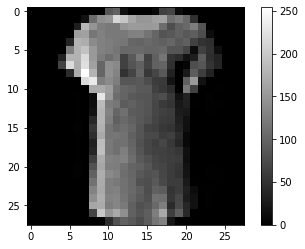

In [4]:
plt.figure()
plt.imshow(train_images[600], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### Preprocessing

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
# convert image grids to 1-D vector
X_train = train_images.reshape(60000, 784).copy()
X_test = test_images.reshape(10000, 784).copy()

In [7]:
# normalize 0-255 grayscale values to 0-1
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [8]:
# each column in the describe is a pixel, looks like scaling worked as intended
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.000003,0.000023,0.000118,0.000407,0.000979,0.001626,0.003222,0.008724,0.022348,0.056606,0.129239,0.180073,0.204285,0.199492,0.198129,0.211398,0.202068,0.159425,0.102429,0.040818,0.016112,0.007763,0.004633,0.003335,0.001870,0.001021,0.000383,0.000066,0.000028,0.000094,0.000396,0.001427,0.003019,0.008172,0.028851,0.068769,0.125668,0.207565,0.312554,0.392771,...,0.362699,0.355165,0.310451,0.244422,0.179115,0.172847,0.187552,0.151842,0.087102,0.035749,0.014837,0.002386,0.000092,0.000834,0.003892,0.017036,0.049189,0.081401,0.082413,0.067014,0.086400,0.119424,0.163663,0.202170,0.206347,0.182296,0.167277,0.177297,0.196521,0.182244,0.135547,0.091014,0.065005,0.069929,0.089878,0.070262,0.033277,0.010613,0.003212,0.000278
std,0.000363,0.000977,0.003011,0.009851,0.016986,0.022853,0.032588,0.055693,0.093474,0.149822,0.226520,0.259458,0.269199,0.266398,0.264524,0.272712,0.266733,0.246441,0.203073,0.127585,0.079234,0.055366,0.042187,0.036157,0.027389,0.020204,0.011509,0.004841,0.002220,0.005280,0.011971,0.025528,0.038663,0.062336,0.118341,0.188953,0.257516,0.322504,0.374746,0.391674,...,0.396046,0.391653,0.373349,0.348269,0.307776,0.302520,0.326557,0.291742,0.218760,0.147384,0.095606,0.031384,0.003637,0.017291,0.038322,0.081465,0.144478,0.191166,0.188837,0.165280,0.189087,0.215365,0.243522,0.268675,0.273705,0.264613,0.260046,0.261685,0.269304,0.259218,0.225717,0.191692,0.164880,0.172201,0.203641,0.177152,0.115485,0.067681,0.035817,0.008141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [9]:
# showing explicitly that values are between 0 and 1
pd.DataFrame(X_test_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.050980,0.262745,0.000000,0.000000,0.000000,0.000000,0.196078,0.149020,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.031373,0.470588,0.819608,0.886275,0.968627,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.152941,0.976471,1.0,0.482353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192157,0.803922,0.772549,0.043137,0.0,0.015686,0.003922,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,0.262745,0.694118,0.505882,0.600000,0.458824,0.505882,0.572549,0.552941,0.686275,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.007843,0.000000,0.768627,1.000000,...,0.631373,1.000000,0.988235,0.466667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.384314,0.623529,0.278431,0.000000,0.000000,0.266667,0.690196,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,0.482353,0.423529,0.388235,0.388235,0.329412,0.325490,0.337255,0.360784,0.274510,0.023529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.415686,0.972549,0.901961,...,0.878431,0.972549,0.180392,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.078431,0.682353,0.396078,0.000000,0.000000,0.000000,0.572549,0.572549,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,0.000000,0.223529,0.262745,0.286275,0.298039,0.298039,0.325490,0.243137,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.003922,0.003922,0.0,0.000000,0.050980,0.309804,0.501961,0.788235,...,0.611765,0.682353,0.772549,0.713725,0.635294,0.239216,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.117647,0.282353,0.372549,0.427451,0.435294,0.435294,0.415686,0.396078,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [10]:
pd.Series(train_labels).value_counts()

# we have a nice even distribution
# ... by design

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [11]:
# one hot encode the
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Model Building

I will start building some naive models and adjusting parameters

I'm going to start building some feed-forward neaurl nets to experiment with different hyperparameters. 

In [12]:
# define some aspects of the data to pass inot the nn's

input_dim = X_train.shape[1] # num features (cols) in the train data
output_dim = y_train.shape[1] # num of classes

In [13]:
# a handy function for quickly initializing ann
def init_model(
    input_dim,
    output_dim=1,
    layer_nodes=[64, 32, 32],
    activation_function="relu",
    output_function="sigmoid",
):
    model = Sequential()
    model.add(
        Dense(layer_nodes[0], input_dim=input_dim, activation=activation_function)
    )
    for i in range(1, len(layer_nodes)):
        model.add(Dense(layer_nodes[i], activation=activation_function))

    model.add(Dense(output_dim, activation=output_function))

    return model

In [14]:
def model_eval(model, history, test_data, true_test_labels):
  preds = np.argmax(model.predict(test_data), axis=-1)
  
  # print the confusion matrix
  print(pd.DataFrame(confusion_matrix(true_test_labels, preds)))

  # plot accuracy over epoch training
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # plot loss over epochs
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


In [15]:
X_train.shape

(60000, 784)

In [16]:
# first model, 2 hidden layers with 64 and 32 nodes
model1 = init_model(input_dim=input_dim, output_dim=output_dim, layer_nodes=[64, 32], output_function='softmax')

# use adam optimizer, which is configurable, 
# categorical_crossentropy and accuracy are obligatory for multiclass 
# classification problems, 
model1.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

# start with 32 samples in batch.
# with 6,000 training observations, the network will update 187 times per epoch
history = model1.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59424/60000 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.8138WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
60000/60000 [==============================] - 4s 68us/sample - loss: 0.5285 - accuracy: 0.8140 - val_loss: 0.4410 - val_accuracy: 0.8419
Epoch 2/20
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3913 - accuracy: 0.8590 - val_loss: 0.4092 - val_accuracy: 0.8539
Epoch 3/20
60000/60000 [==============================] - 4s 66us/sample - loss: 0.3516 - accuracy: 0.8717 - val_loss: 0.3838 - val_accuracy: 0.8632
Epoch 4/20
60000/60000 [==============================] - 4s 

In [17]:
y_pred1 = np.argmax(model1.predict(X_test_scaled), axis=-1)
print('test')
pd.DataFrame(confusion_matrix(test_labels, y_pred1)).style.background_gradient()


test


,0,1,2,3,4,5,6,7,8,9
0,825,2,29,17,1,2,121,0,2,1
1,3,971,3,18,2,1,2,0,0,0
2,18,0,848,10,74,0,49,0,1,0
3,20,3,22,892,28,0,32,0,3,0
4,1,1,142,36,769,0,50,0,1,0
5,1,0,0,1,0,971,0,15,0,12
6,109,1,127,20,66,0,674,0,3,0
7,0,0,0,0,0,16,0,949,0,35
8,10,1,7,4,4,3,10,2,959,0
9,2,0,0,0,0,12,1,23,0,962


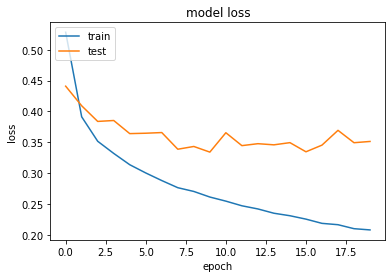

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This simple, naive network did alright, but is pretty paltry for neural nets with 92%/88% train/test accuracy. More epochs might help, but judging from the loss vs epochs plot, the model is only learning so much about the data. After about where the train and test losses cross, the training data starts memorizing the data , as indicated by the linear trend and the essentially flatline of the validation scores. Let's add some complexity and see if we can get the model to learn more with more epochs

In [19]:
# first model, 2 hidden layers with 64 and 32 nodes
model2 = init_model(input_dim=input_dim, output_dim=output_dim, layer_nodes=[64, 32], output_function='softmax')

# use adam optimizer, which is configurable, 
# categorical_crossentropy and accuracy are obligatory for multiclass 
# classification problems, 
model2.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

# start with 32 samples in batch.
# with 6,000 training observations, the network will update 187 times per epoch
history2 = model2.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, epochs=50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 69us/sample - loss: 0.5302 - accuracy: 0.8149 - val_loss: 0.4491 - val_accuracy: 0.8405
Epoch 2/50
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3871 - accuracy: 0.8619 - val_loss: 0.3980 - val_accuracy: 0.8568
Epoch 3/50
60000/60000 [==============================] - 4s 71us/sample - loss: 0.3489 - accuracy: 0.8734 - val_loss: 0.3817 - val_accuracy: 0.8599
Epoch 4/50
60000/60000 [==============================] - 4s 71us/sample - loss: 0.3252 - accuracy: 0.8805 - val_loss: 0.3538 - val_accuracy: 0.8729
Epoch 5/50
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3077 - accuracy: 0.8863 - val_loss: 0.3557 - val_accuracy: 0.8744
Epoch 6/50
60000/60000 [==============================] - 4s 68us/sample - loss: 0.2960 - accuracy: 0.8904 - val_loss: 0.3517 - val_accuracy: 0.8785
Epoch 7/50
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  827    3   32   18    3    4  106    0    7    0
1    3  974    3   13    3    0    3    0    1    0
2   18    0  857    5   56    0   59    0    5    0
3   29    6   30  875   22    0   32    0    6    0
4    0    0  131   33  754    0   75    0    7    0
5    0    0    0    2    0  960    0   21    2   15
6  134    2  113   17   46    0  674    0   14    0
7    0    0    0    0    0   14    0  962    0   24
8    4    0    4    3    3    2    4    4  976    0
9    0    0    0    0    0    9    1   28    0  962


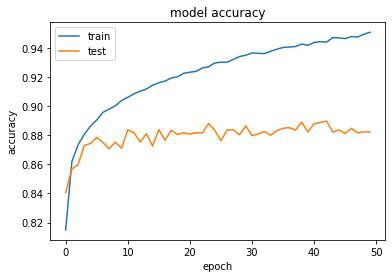

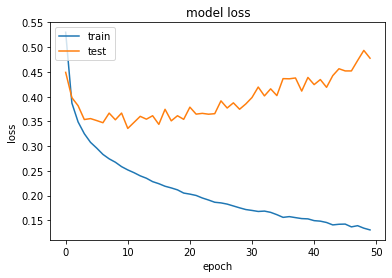

In [20]:
model_eval(model2, history2, X_test_scaled, test_labels)

Adding more epochs lead to terrible overfitting! The model continues to memorize the training data and perform progressively worse on the test. I'll add some complexity to the model to capture more features.

In [21]:
# 3rd model, 3 hidden layers with 128, 64 and 32 nodes
model3 = init_model(input_dim=input_dim, output_dim=output_dim, layer_nodes=[128, 64, 32], output_function='softmax')

# use adam optimizer, which is configurable, 
# categorical_crossentropy and accuracy are obligatory for multiclass 
# classification problems, 
model3.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

# start with 32 samples in batch.
# with 6,000 training observations, the network will update 187 times per epoch
# 6,000 / 32
history3 = model3.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.5043 - accuracy: 0.8199 - val_loss: 0.4169 - val_accuracy: 0.8460
Epoch 2/20
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3702 - accuracy: 0.8640 - val_loss: 0.3869 - val_accuracy: 0.8594
Epoch 3/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3381 - accuracy: 0.8756 - val_loss: 0.4368 - val_accuracy: 0.8256
Epoch 4/20
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3149 - accuracy: 0.8834 - val_loss: 0.3930 - val_accuracy: 0.8594
Epoch 5/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2985 - accuracy: 0.8887 - val_loss: 0.3546 - val_accuracy: 0.8763
Epoch 6/20
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2837 - accuracy: 0.8939 - val_loss: 0.3379 - val_accuracy: 0.8788
Epoch 7/20
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  843    2   20   18    4    0  106    0    7    0
1    4  979    2    8    5    0    1    0    1    0
2   11    1  844    5   90    0   48    0    1    0
3   25   12   15  874   52    0   18    0    4    0
4    1    0   95   17  820    1   65    0    1    0
5    0    0    0    0    0  980    0   13    1    6
6  116    1  101   26   66    0  685    0    5    0
7    0    0    1    0    0   22    0  969    0    8
8    3    0    2    5    8    3    4    2  973    0
9    0    0    0    0    0   13    1   57    1  928


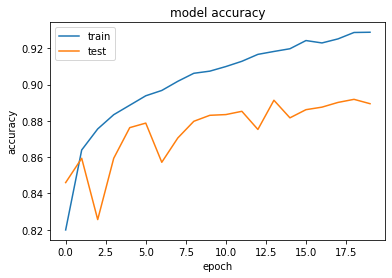

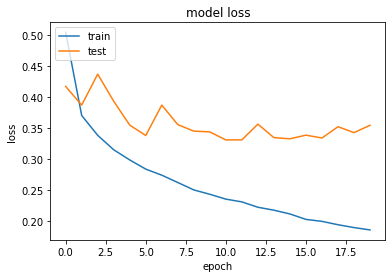

In [22]:
model_eval(model3, history3, X_test_scaled, test_labels)

Adding an extra layer didn't do too much, our testing accuracy is topping out at about 88%. With 187 updates times 20 epochs, the networks parameters update 3,740 times. This is small in the grand scheme of things, but increasing the bacth size should reduce overfitting by reducing the number of times the wieghts update, while also improving runtime.

In [23]:
# 4th model, 3 hidden layers with 128, 64 and 32 nodes
model4 = init_model(input_dim=input_dim, output_dim=output_dim, layer_nodes=[128, 64, 32], output_function='softmax')

# use adam optimizer, which is configurable, 
# categorical_crossentropy and accuracy are obligatory for multiclass 
# classification problems, 
model4.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

# double batch size to 64
# with 6,000 training observations, the network will update 93 times per epoch
# 6,000 // 64
history4 = model4.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=64, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.5298 - accuracy: 0.8121 - val_loss: 0.4357 - val_accuracy: 0.8415
Epoch 2/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3834 - accuracy: 0.8606 - val_loss: 0.3943 - val_accuracy: 0.8599
Epoch 3/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.3424 - accuracy: 0.8734 - val_loss: 0.3854 - val_accuracy: 0.8575
Epoch 4/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3164 - accuracy: 0.8842 - val_loss: 0.3708 - val_accuracy: 0.8672
Epoch 5/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.3009 - accuracy: 0.8892 - val_loss: 0.3685 - val_accuracy: 0.8674
Epoch 6/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.2870 - accuracy: 0.8926 - val_loss: 0.3372 - val_accuracy: 0.8809
Epoch 7/20
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  756    0   17   31    2    1  188    0    5    0
1    2  959    6   22    4    0    6    0    1    0
2   10    0  857   13   42    0   76    0    2    0
3   11    4   14  911   26    0   30    0    4    0
4    1    0  137   27  727    0  105    0    3    0
5    0    0    0    0    0  967    0   23    2    8
6   68    0   75   29   40    0  780    0    8    0
7    0    0    0    0    0    8    0  980    0   12
8    3    0    8    3    1    6    2    3  974    0
9    0    0    0    0    0   17    2   68    0  913


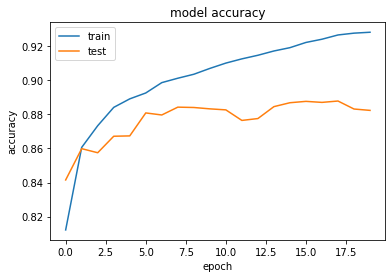

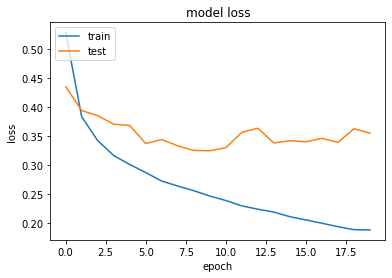

In [24]:
model_eval(model4, history4, X_test_scaled, test_labels)

That increase in batch size didn't change much. I'll double it again.

In [25]:
# 5th model, 3 hidden layers with 128, 64 and 32 nodes
model5 = init_model(input_dim=input_dim, output_dim=output_dim, layer_nodes=[128, 64, 32], output_function='softmax')

# use adam optimizer, which is configurable, 
# categorical_crossentropy and accuracy are obligatory for multiclass 
# classification problems, 
model5.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

# double batch size to 128
# with 6,000 training observations, the network will update 46 times per epoch
# 6,000 // 128
history5 = model5.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=128, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.5872 - accuracy: 0.7950 - val_loss: 0.4654 - val_accuracy: 0.8334
Epoch 2/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3983 - accuracy: 0.8574 - val_loss: 0.4193 - val_accuracy: 0.8530
Epoch 3/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3531 - accuracy: 0.8723 - val_loss: 0.4037 - val_accuracy: 0.8549
Epoch 4/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3251 - accuracy: 0.8807 - val_loss: 0.3642 - val_accuracy: 0.8674
Epoch 5/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3091 - accuracy: 0.8866 - val_loss: 0.3542 - val_accuracy: 0.8737
Epoch 6/20
60000/60000 [==============================] - 1s 23us/sample - loss: 0.2971 - accuracy: 0.8906 - val_loss: 0.3519 - val_accuracy: 0.8738
Epoch 7/20
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  798    7    9   16    4    3  151    0   12    0
1    0  985    0    8    4    0    2    0    1    0
2   24    1  788   13  104    0   63    0    7    0
3   21   21    8  881   36    0   29    0    4    0
4    4    2   80   28  849    0   32    0    5    0
5    0    0    0    0    0  964    0   14    3   19
6   80    2   72   22  118    0  694    0   12    0
7    0    0    0    0    0   21    0  953    6   20
8    4    0    2    8    2    2    0    1  980    1
9    0    0    0    1    0   11    1   29    0  958


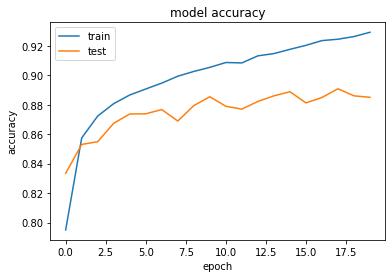

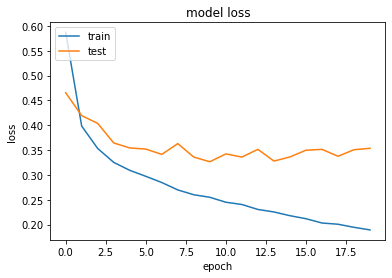

In [26]:
model_eval(model5, history5, X_test_scaled, test_labels)

So far, these models are pretty shallow, and manipulating the batches didn't give too much change. I'm going to add a few more layers, and add dropout to see if I can overcome the overfitting. I'll hard code this model so I can put in my drop out layers.

In [27]:
model6 = Sequential()
model6.add(Dense(128, input_dim=input_dim, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(y_train.shape[1], activation='softmax'))


In [28]:
model6.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])


In [29]:
history6 = model6.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=128, epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 49us/sample - loss: 1.0035 - accuracy: 0.6260 - val_loss: 0.5613 - val_accuracy: 0.7895
Epoch 2/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.6078 - accuracy: 0.7868 - val_loss: 0.4913 - val_accuracy: 0.8237
Epoch 3/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.5286 - accuracy: 0.8209 - val_loss: 0.4529 - val_accuracy: 0.8464
Epoch 4/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.4840 - accuracy: 0.8393 - val_loss: 0.4228 - val_accuracy: 0.8521
Epoch 5/20
60000/60000 [==============================] - 3s 48us/sample - loss: 0.4585 - accuracy: 0.8460 - val_loss: 0.4162 - val_accuracy: 0.8602
Epoch 6/20
60000/60000 [==============================] - 3s 47us/sample - loss: 0.4403 - accuracy: 0.8511 - val_loss: 0.4000 - val_accuracy: 0.8524
Epoch 7/20
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  838    3   13   49    2    1   90    0    4    0
1    2  964    0   27    3    0    3    0    1    0
2   12    0  764   12  160    1   51    0    0    0
3   18    4    5  899   43    0   28    0    3    0
4    0    0   91   27  845    0   35    0    2    0
5    0    0    0    1    0  972    0   20    1    6
6  161    2  103   39   94    0  590    0   11    0
7    0    0    0    0    0   14    0  974    0   12
8    0    0    1    5    5    3   13    2  971    0
9    0    0    0    0    0    9    1   50    0  940


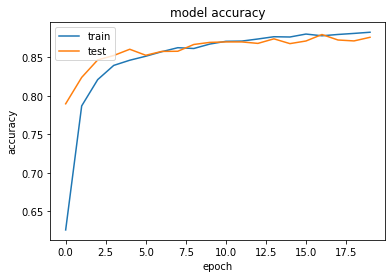

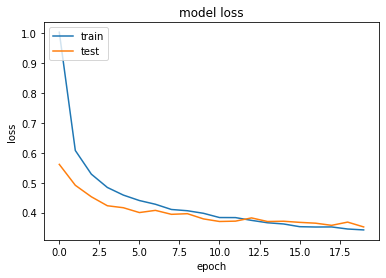

In [30]:
model_eval(model6, history6, X_test_scaled, test_labels)

Voila! Our loss and accuracy graphs appear different from every model so far. Notably, the loss for the validation finally decreases along with the training data, and there is no longer a large gap in the accuracies. I'll run this again with more epochs to see if the validatiopn accuracy continues to increase.

In [31]:
model7 = Sequential()
model7.add(Dense(128, input_dim=input_dim, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(32, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(32, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(y_train.shape[1], activation='softmax'))

In [32]:
model7.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])
history7 = model7.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=128, epochs=50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 50us/sample - loss: 1.0943 - accuracy: 0.5738 - val_loss: 0.6031 - val_accuracy: 0.7437
Epoch 2/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.6499 - accuracy: 0.7468 - val_loss: 0.5288 - val_accuracy: 0.7973
Epoch 3/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.5643 - accuracy: 0.7966 - val_loss: 0.4763 - val_accuracy: 0.8307
Epoch 4/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.5084 - accuracy: 0.8272 - val_loss: 0.4490 - val_accuracy: 0.8454
Epoch 5/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.4711 - accuracy: 0.8402 - val_loss: 0.4103 - val_accuracy: 0.8552
Epoch 6/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.4478 - accuracy: 0.8503 - val_loss: 0.4080 - val_accuracy: 0.8559
Epoch 7/50
60000/60000 [==============================] 

     0    1    2    3    4    5    6    7    8    9
0  860    1   16   24    3    2   91    0    3    0
1    1  970    1   22    3    0    2    0    1    0
2   12    0  799   12  125    0   50    1    1    0
3   31    5   10  898   31    0   21    0    4    0
4    0    0   77   37  835    0   50    0    1    0
5    0    0    0    1    0  964    0   20    0   15
6  146    0  100   31   88    0  626    0    9    0
7    0    0    0    0    0   11    0  959    0   30
8    0    0    4    4    3    2    9    5  973    0
9    0    0    0    0    0    7    1   26    0  966


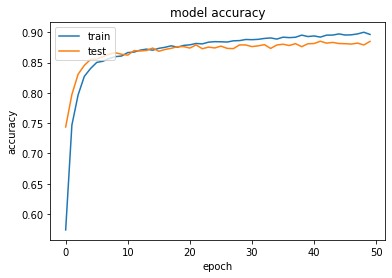

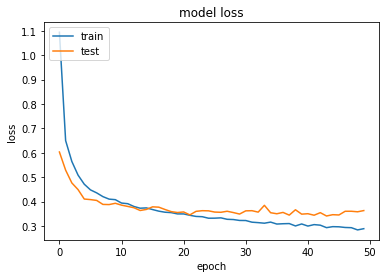

In [33]:
model_eval(model7, history7, X_test_scaled, test_labels)

It appears that the validation scores maxes out at around 88% accurate. During the extra epochs,the neural network is again memorizing the trianing data. We can see that most of the learning is happening in the first few epochs, about 10. Relu activation and adam optimization are generally best, and other options for these parameters I belive to be case specific, such as using hyperbolic tangent activation for the internals of recurrent nueral nets. 88% accuracy is not great for neural networks, but these naive, rudimentary networks aren't neccesarily suited to an image classification like this anyways. A convultional and pooling architecture should increase performance. However, with these images as simple as they are, pooling may not even be needed. And at the end of the day, using well established networks like VGG16 or LeNet as a starting point would be the most efficient practice. For the sake of this challenge, I am happy to have over come the over fitting, and hopefully cleaerly demonstrated the affects of different hyper parameters on the nueral networks.